# Predicting Taxi Demand: A Machine Learning Approach for Optimized Driver Allocation

# Introduction

In this project, we aim to develop a predictive model for Sweet Lift Taxi to forecast the number of taxi orders at airports for the next hour. Accurate demand forecasting will help the company attract more drivers during peak hours, ensuring better service availability and reducing passenger wait times.

To achieve this, we will analyze historical order data, preprocess it by resampling to hourly intervals, and explore different machine learning models with optimized hyperparameters. The model's performance will be evaluated using the Root Mean Squared Error (RMSE) metric, with a target threshold of no more than 48 on the test set.

By implementing this solution, Sweet Lift Taxi can optimize driver allocation, improve operational efficiency, and enhance customer satisfaction through better demand-supply balance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [2]:
df = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project13/taxi.csv', parse_dates=[0], index_col=[0])
#df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
df.head()

/var/folders/2c/tfkhfg6d5jj1g3ttv18s3t5r0000gn/T/ipykernel_82638/4200362086.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project13/taxi.csv', parse_dates=[0], index_col=[0])


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df = df.resample("1h").sum() # Resampling the data by hour

In [4]:
print(df.index.is_monotonic_increasing)
print(df.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


The dataset only has 1 column, and the data type is correct.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


We have instances where no orders were made (0). The data is being pulled every 10 minutes, so being that the data is pulled in 10 minute increments it makes sense. I will leave those entries.

## Preparation

In [7]:
df.isnull().sum()

num_orders    0
dtype: int64

### 24 Hour Moving Average

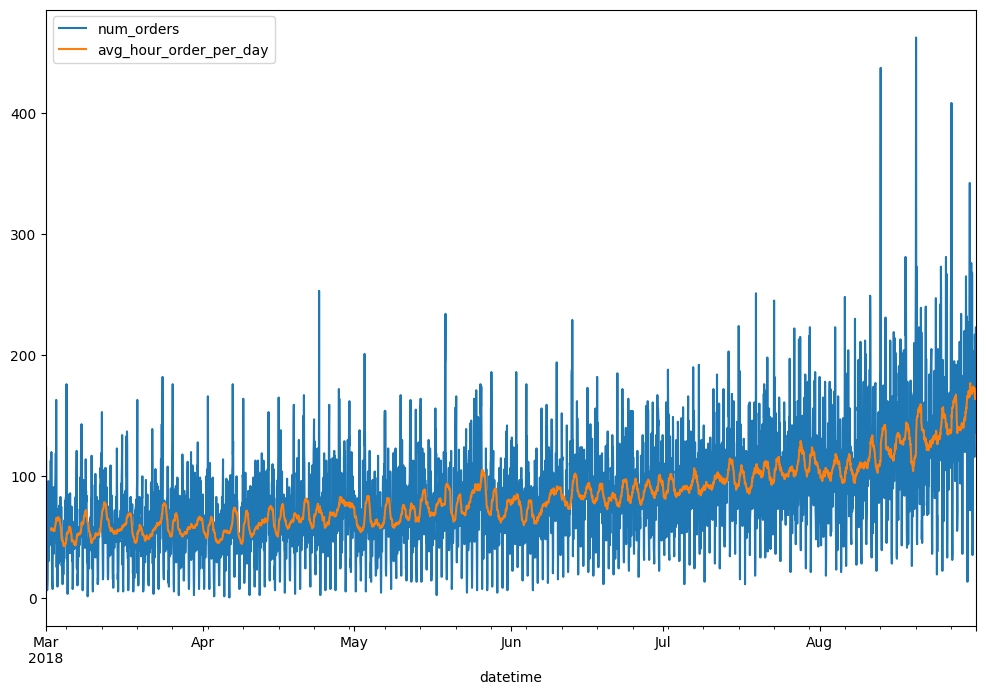

In [8]:
df['avg_hour_order_per_day'] = df.shift().rolling(24).mean()
df.plot(figsize=(12,8))
plt.show()

Although the data fluctuates quite dramatically. It's not hard to identify there is increasing trend along with time.

### Feature Engineering

In [9]:
def make_features(data, max_lag, rolling_window):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data[f'rolling_mean_{rolling_window}'] = data['num_orders'].shift(1).rolling(rolling_window).mean()

make_features(df, max_lag=23, rolling_window=5)
df.head()

,num_orders,avg_hour_order_per_day,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rolling_mean_5
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis

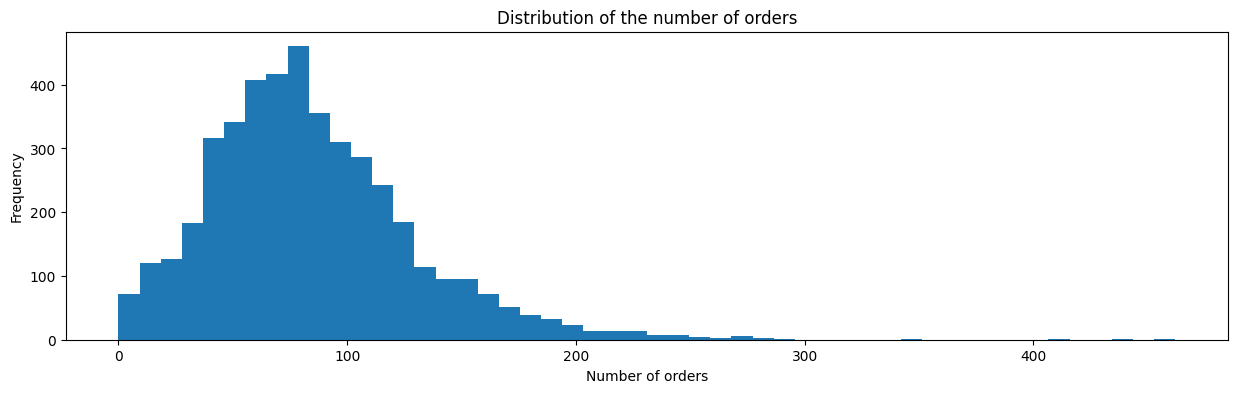

In [10]:
ax = df['num_orders'].plot(kind='hist', bins=50, figsize=(15,4))
ax.set_title('Distribution of the number of orders')
ax.xaxis.set_label_text('Number of orders')
ax.yaxis.set_label_text('Frequency')
plt.show()

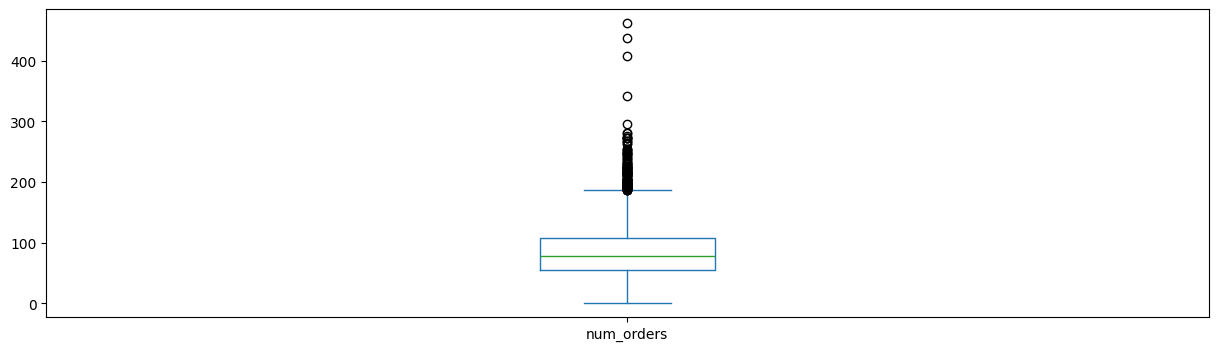

In [11]:
df['num_orders'].plot(kind='box', figsize=(15, 4))
plt.show()

### Relationship between Orders and Lag_1

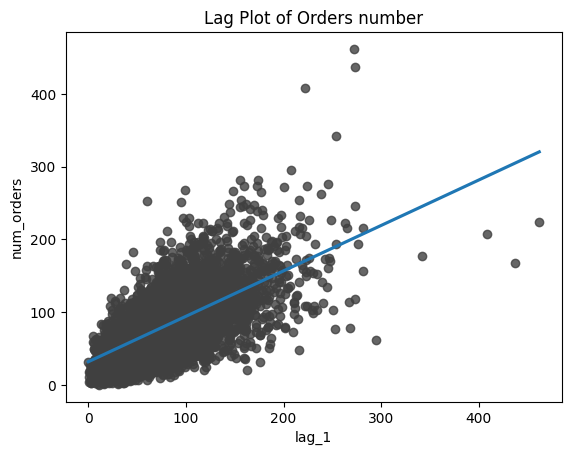

In [12]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='num_orders', data=df[['num_orders', 'lag_1']], ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Lag Plot of Orders number')
plt.show()

Number of orders at one-hour intervals looks to be correlated with lag_1, so the lag features should be useful.

### Trends and Seasonality

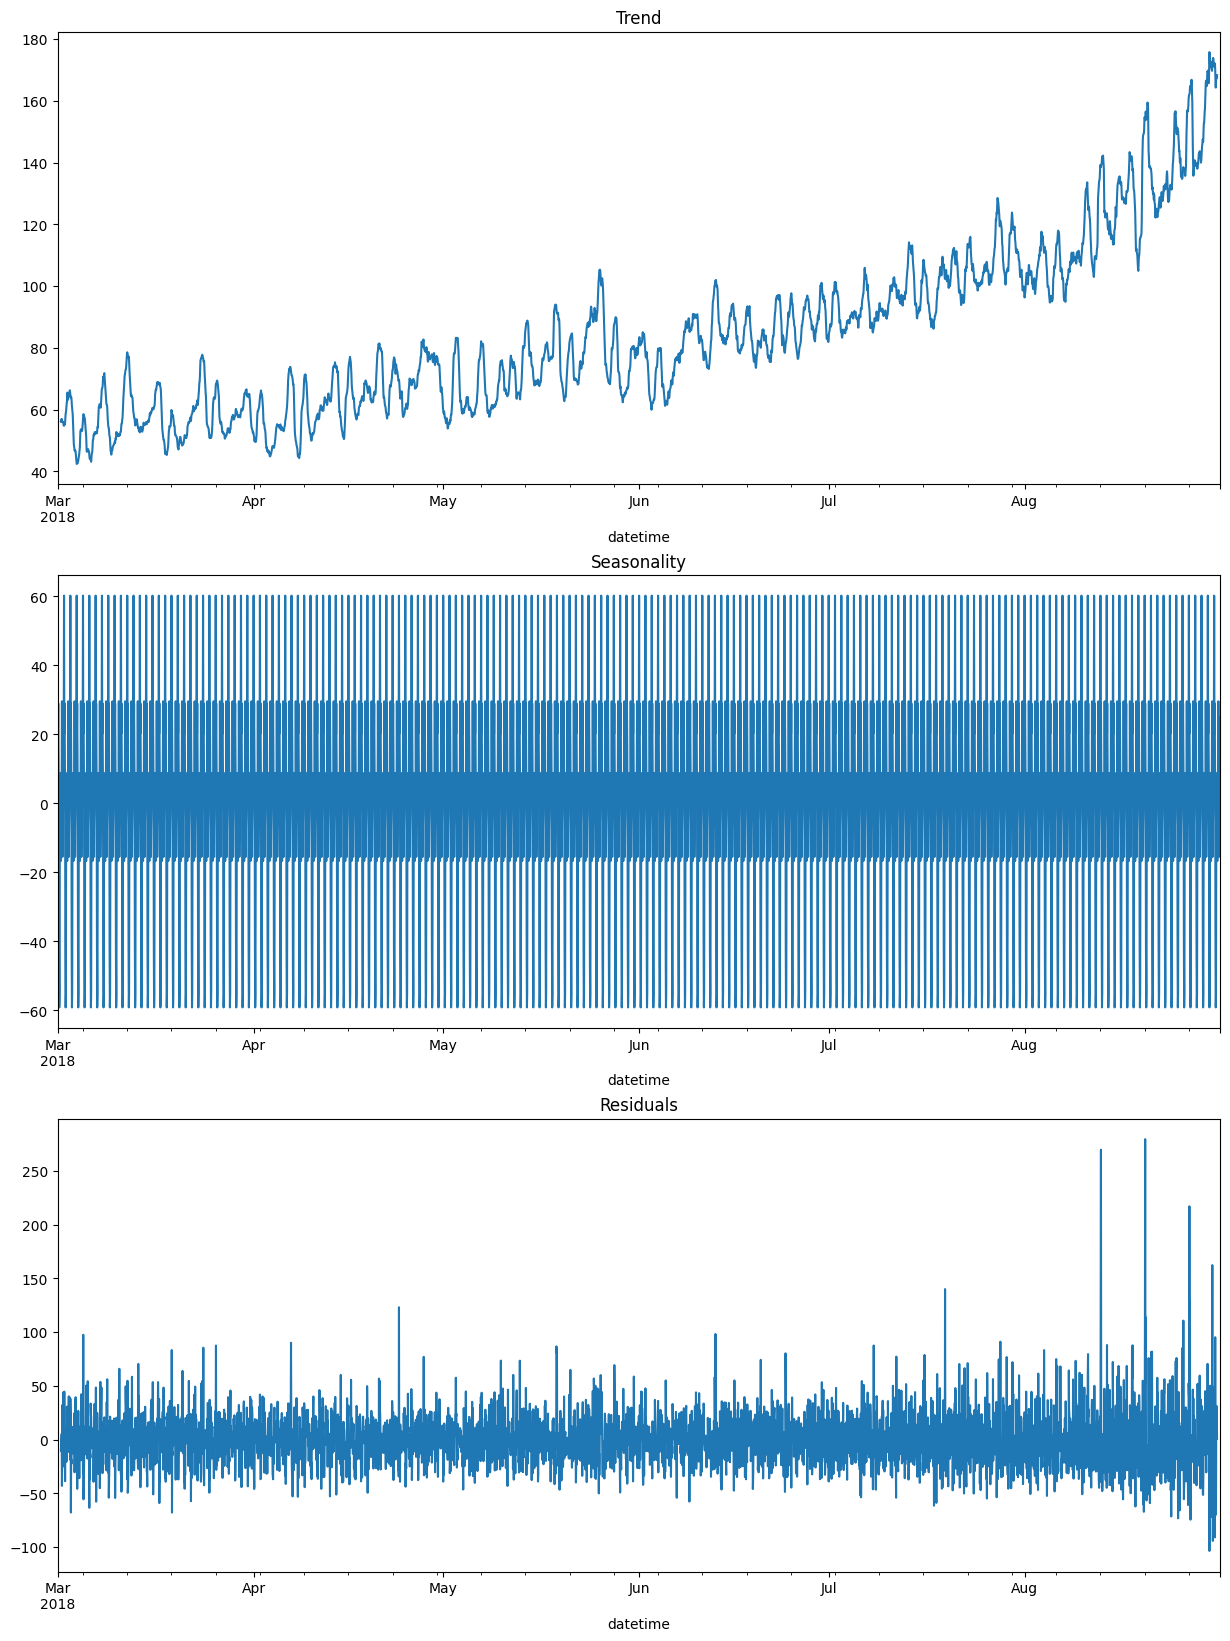

In [13]:
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.show()





Can't tell much from the Seasonality chart here so I will take a smaller sample size to see if I can see a trend in Seasonality.

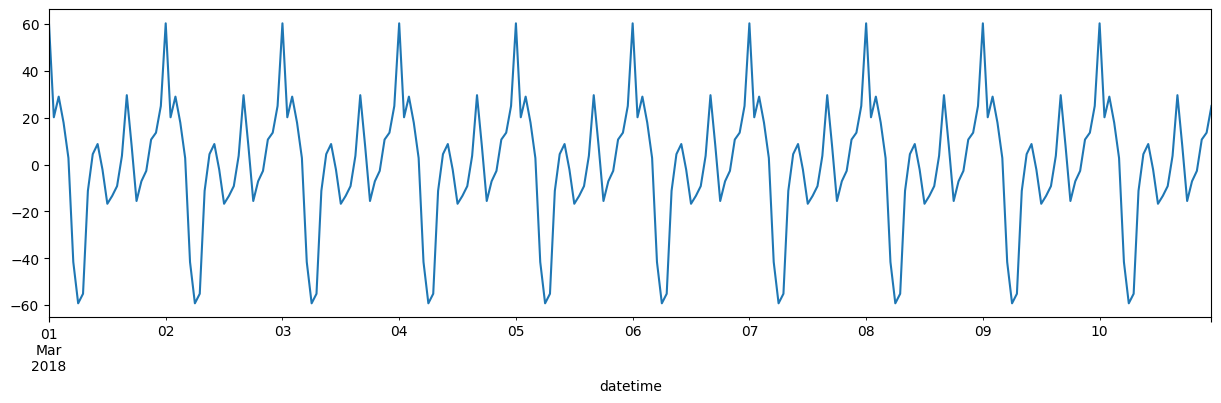

In [14]:
decomposed.seasonal['2018-03-01':'2018-03-10'].plot(figsize=(15,4))
plt.show()

Trend, Seasonality and Residual
* Trend: Steady rising over time, meaning the process is non-stationary.
* Seasonality: High number of orders around midnight, drops off early in the morning and steady rises throughout the day. Peaks again towards night time. Ranges from -60 to +60.
* Residual: Random noise

## Training

### Encoding for Linear Regression

I will first split the dataset then encode for Linear Regression

In [15]:
df = df.dropna()

### Training with Default Settings
I will first train with the default settings, I'm going to use the following models:
* Linear Regression
* Random Forest
* XGBoost
* LightGBM
* CatBoost

In [16]:
# Step 1: Defined the categorical columns
categorical = ['month', 'day', 'hour', 'dayofweek']

In [17]:
# Step 2: Train-test split function
def train_test_prepare(df, target, test_size):
    X = df.drop([target], axis=1)
    y = df[target]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=11, shuffle=False)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=11, shuffle=False)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [18]:
# Step 3: Apply train-test split
X_train, y_train, X_val, y_val, X_test, y_test = train_test_prepare(df, 'num_orders', 0.2)

In [20]:
# Step 4: Initialize OneHotEncoder with correct parameters
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

In [21]:
# Step 5: Fit and transform categorical columns for training.. Transform categorical columns for validation and test sets
X_train_ohe = encoder.fit_transform(X_train[categorical])
X_val_ohe = encoder.transform(X_val[categorical])
X_test_ohe = encoder.transform(X_test[categorical])


/opt/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [23]:
# Step 6: Get the feature names after encoding
ohe_columns = encoder.get_feature_names_out(categorical)

In [24]:
# Step 7: Convert the OHE results back to DataFrame and maintain index
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_columns, index=X_train.index)
X_val_ohe = pd.DataFrame(X_val_ohe, columns=ohe_columns, index=X_val.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_columns, index=X_test.index)

In [25]:
# Step 8: Drop original categorical columns and concatenate the OHE columns
X_train_ohe = pd.concat([X_train.drop(columns=categorical), X_train_ohe], axis=1)
X_val_ohe = pd.concat([X_val.drop(columns=categorical), X_val_ohe], axis=1)
X_test_ohe = pd.concat([X_test.drop(columns=categorical), X_test_ohe], axis=1)

Creating a pipeline for training, predicting and scoring the model.

In [26]:
models_name = []
training_time_list = []
predict_time_list = []
rmse_list = []

def train_pipeline(X_train, X_val, y_train, y_val, model_name, model_obj, lightGBM_params={}):
    models_name.append(model_name)
    
    # Check if scaling is needed (only for non-tree model(s))
    scale_needed = model_name in ['Linear Regression']
    
    if scale_needed:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
    
    # Train the model
    start = time.time()
    if model_name in ['LightGBM', 'Optimized LightGBM']:
        train_data = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(lightGBM_params, train_data)
    elif model_name in ['CatBoost', 'Optimized CatBoost']:
        model = model_obj
        model.fit(X_train, y_train, verbose=250)
    else:
        model = model_obj
        model.fit(X_train, y_train)
    
    training_time = round((time.time() - start), 3)
    training_time_list.append(training_time)

    # Predict
    predict_start = time.time()
    y_pred = model.predict(X_val)

    # Score
    mse = mean_squared_error(y_val, y_pred)
    rmse =  np.sqrt(mse)
    predict_time = round((time.time() - predict_start), 3)

    print(f"The RMSE of {model_name} is: {rmse:.1f}")
    
    predict_time_list.append(predict_time)
    rmse_list.append(rmse)
    
    return model  # Returning trained model for later evaluation


In [27]:
model_list_default_training = ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
model_objects = [LinearRegression(), RandomForestRegressor(), xgb.XGBRegressor(), None, ctb.CatBoostRegressor()]
for i in range(len(model_list_default_training)):
    if model_list_default_training[i] == 'Linear Regression':
        train_pipeline(X_train_ohe, X_val_ohe, y_train, y_val, model_list_default_training[i], model_objects[i])
    else:
        train_pipeline(X_train, X_val, y_train, y_val, model_list_default_training[i], model_objects[i])

The RMSE of Linear Regression is: 47.6
The RMSE of Random Forest is: 31.7
The RMSE of XGBoost is: 33.5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4627
[LightGBM] [Info] Number of data points in the train set: 3513, number of used features: 29
[LightGBM] [Info] Start training from score 74.421862
The RMSE of LightGBM is: 31.9
Learning rate set to 0.049934
0:	learn: 34.9777928	total: 59.7ms	remaining: 59.6s
250:	learn: 17.3512020	total: 363ms	remaining: 1.08s
500:	learn: 13.8967297	total: 650ms	remaining: 648ms
750:	learn: 11.4949432	total: 935ms	remaining: 310ms
999:	learn: 9.7581245	total: 1.22s	remaining: 0us
The RMSE of CatBoost is: 32.0


### These are results with Default settings, I will now fine tune.

I'm going to create a function that will be used to find the best hyperparameters.

I'll apply the RandomSearchCV to find the best hyperparameters.

In [28]:
def random_optimize(estimator, param_grid, X_train, y_train, n_iter):
    tscv = TimeSeriesSplit(n_splits=5)
    random_search = RandomizedSearchCV(estimator=estimator, 
                                       param_distributions=param_grid, 
                                       n_iter=n_iter, cv=tscv,
                                       scoring='neg_mean_squared_error')
    random_search.fit(X_train, y_train)
    print("Best parameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)
    return random_search.best_params_

#### Hyperparameter Grid for Random Forest

In [29]:
param_grid_rfr = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4, 8]
}

#### Applying best parameters to Training Set

In [30]:
best_params_rfr = random_optimize(RandomForestRegressor(random_state=42), param_grid_rfr, X_train, y_train, n_iter=15)

Best parameters:  {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': None}
Best score:  -600.2857571460493


In [31]:
train_pipeline(X_train, X_val, y_train, y_val, "Optimized Random Forest", RandomForestRegressor(random_state=42, **best_params_rfr))

The RMSE of Optimized Random Forest is: 31.8


RandomForestRegressor(min_samples_leaf=2, min_samples_split=4, n_estimators=200,
                      random_state=42)

#### Hyperparameter Grid for CatBoost

In [32]:
param_grid_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
}
best_params_cat = random_optimize(ctb.CatBoostRegressor(random_state=42), param_grid_cat, X_train, y_train, n_iter=10)

0:	learn: 29.9862898	total: 1.32ms	remaining: 263ms
1:	learn: 29.8706316	total: 2.1ms	remaining: 208ms
2:	learn: 29.7239869	total: 2.93ms	remaining: 192ms
3:	learn: 29.5730458	total: 3.37ms	remaining: 165ms
4:	learn: 29.4601391	total: 4.54ms	remaining: 177ms
5:	learn: 29.3372728	total: 4.83ms	remaining: 156ms
6:	learn: 29.2009477	total: 5.14ms	remaining: 142ms
7:	learn: 29.0869453	total: 5.49ms	remaining: 132ms
8:	learn: 28.9553896	total: 6ms	remaining: 127ms
9:	learn: 28.8213428	total: 6.52ms	remaining: 124ms
10:	learn: 28.7040619	total: 6.97ms	remaining: 120ms
11:	learn: 28.5825855	total: 7.38ms	remaining: 116ms
12:	learn: 28.4683603	total: 7.85ms	remaining: 113ms
13:	learn: 28.3703012	total: 8.4ms	remaining: 112ms
14:	learn: 28.2392702	total: 8.77ms	remaining: 108ms
15:	learn: 28.1099130	total: 9.26ms	remaining: 107ms
16:	learn: 28.0084763	total: 9.78ms	remaining: 105ms
17:	learn: 27.8824683	total: 10.2ms	remaining: 103ms
18:	learn: 27.7964987	total: 11.4ms	remaining: 109ms
19:	lear

In [33]:
train_pipeline(X_train, X_val, y_train, y_val, "Optimized CatBoost", ctb.CatBoostRegressor(random_state=42, **best_params_cat))

0:	learn: 35.0148059	total: 1.27ms	remaining: 381ms
250:	learn: 17.1352914	total: 327ms	remaining: 63.9ms
299:	learn: 16.2956629	total: 385ms	remaining: 0us
The RMSE of Optimized CatBoost is: 31.9


#### Hyperparameter Grid for LightGBM

In [34]:
param_grid_light = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': range(10, 200),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}
best_params_light = random_optimize(lgb.LGBMRegressor(random_state=42), param_grid_light, X_train, y_train, n_iter=10)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2728
[LightGBM] [Info] Number of data points in the train set: 588, number of used features: 28
[LightGBM] [Info] Start training from score 57.340136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [35]:
train_pipeline(X_train, X_val, y_train, y_val, 'Optimized LightGBM', None, lightGBM_params=best_params_light) 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4627
[LightGBM] [Info] Number of data points in the train set: 3513, number of used features: 29
[LightGBM] [Info] Start training from score 74.421862
The RMSE of Optimized LightGBM is: 31.7


#### Hyperparameter Grid for XGBoost

In [36]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
}
best_params_xgb = random_optimize(xgb.XGBRegressor(random_state=42), param_grid_xgb, X_train_ohe, y_train, n_iter=10)

Best parameters:  {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
Best score:  -635.0624755859375


In [37]:
train_pipeline(X_train, X_val, y_train, y_val, 'Optimized XGBoost', xgb.XGBRegressor(random_state=42, **best_params_xgb))


The RMSE of Optimized XGBoost is: 32.2


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [38]:
results = pd.DataFrame({'Model': models_name, 'RMSE': [round(rmse, 1) for rmse in rmse_list], 'Training Time Cost (second)': training_time_list, 'Predict Time Cost (second)': predict_time_list})
results.sort_values(by='RMSE').reset_index(drop=True)

,Model,RMSE,Training Time Cost (second),Predict Time Cost (second)
0,Random Forest,31.7,4.059,0.008
1,Optimized LightGBM,31.7,0.671,0.002
2,Optimized Random Forest,31.8,7.074,0.015
3,LightGBM,31.9,0.168,0.002
4,Optimized CatBoost,31.9,0.405,0.001
5,CatBoost,32.0,1.308,0.003
6,Optimized XGBoost,32.2,0.257,0.003
7,XGBoost,33.5,0.160,0.004
8,Linear Regression,47.6,0.026,0.003


Looking at the results table, `Random Forest` gives you the lowest RMSE, but it takes the 3.8 secs to train and 0.008 secs to predict. `Optimized Random Forest` is next, but `LightGBM` is a VERY close 3rd and trains 19x faster than `Random Forest` and 36x faster than `Optimized Random Forest`. `LightGBM` may be my model of choice. If the dataset were to grow it will be the fastest and has a pretty precise RMSE.

In [39]:
# Function to evaluate models on the test set
def test_evaluator(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Test RMSE for {model_name}: {rmse:.1f}")
    return rmse

# Train Optimized LightGBM on full training set
train_data = lgb.Dataset(X_train, label=y_train)
optimized_lightgbm = lgb.train(best_params_light, train_data)
lightgbm = lgb.train({}, train_data)

# Train Random Forest on full training set
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)

# Train Optimized Random Forest on full training set
optimized_random_forest = RandomForestRegressor(random_state=42, **best_params_rfr)
optimized_random_forest.fit(X_train, y_train)

# Train Optimized XGBoost on full training set
xgboost = xgb.XGBRegressor(random_state=42, **best_params_xgb)
xgboost.fit(X_train, y_train)

# Train XGBoost on full training set
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)

# Evaluate on test set
rmse_lightgbm = test_evaluator(lightgbm, "LightGBM", X_test, y_test)
rmse_opt_lightgbm = test_evaluator(optimized_lightgbm, "Optimized LightGBM", X_test, y_test)
rmse_rf = test_evaluator(random_forest, "Random Forest", X_test, y_test)
rmse_opt_rf = test_evaluator(optimized_random_forest, "Optimized Random Forest", X_test, y_test)
rmse_opt_xgb = test_evaluator(xgboost, "Optimized XGBoost", X_test, y_test)
rmse_xgb = test_evaluator(xgboost, "XGBoost", X_test, y_test)

# Store results in a DataFrame for comparison
test_results = pd.DataFrame({
    "Model": ["LightGBM", "Optimized LightGBM", "Random Forest", "Optimized Random Forest", "Optimized XGBoost", "XGBoost"], 
    "Test RMSE": [rmse_lightgbm, rmse_opt_lightgbm, rmse_rf, rmse_opt_rf, rmse_opt_xgb, rmse_xgb]
})

# Format to 1 decimal place
test_results["Test RMSE"] = test_results["Test RMSE"].round(1)

# Sort by RMSE
test_results = test_results.sort_values(by="Test RMSE").reset_index(drop=True)
test_results


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4627
[LightGBM] [Info] Number of data points in the train set: 3513, number of used features: 29
[LightGBM] [Info] Start training from score 74.421862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4627
[LightGBM] [Info] Number of data points in the train set: 3513, number of used features: 29
[LightGBM] [Info] Start training from score 74.421862
Test RMSE for LightGBM: 54.2
Test RMSE for Optimized LightGBM: 52.8
Test RMSE for Random Forest: 48.9
Test RMSE for Optimized Random Forest: 49.4
Test RMSE for Optimized XGBoost: 54.8
Test RMSE for XGBoost: 54.8


,Model,Test RMSE
0,Random Forest,48.9
1,Optimized Random Forest,49.4
2,Optimized LightGBM,52.8
3,LightGBM,54.2
4,Optimized XGBoost,54.8
5,XGBoost,54.8


In [40]:
final_rf = RandomForestRegressor(
    n_estimators=200,  
    max_depth=None, 
    min_samples_split=8, 
    min_samples_leaf=1, 
    random_state=42
)
final_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=8, n_estimators=200, random_state=42)

# Feature Removal by Importance

In [41]:
importances = final_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


                   Feature  Importance
5                    lag_1    0.239728
3                     hour    0.217436
27                  lag_23    0.054624
0   avg_hour_order_per_day    0.051237
11                   lag_7    0.042859
28          rolling_mean_5    0.036746
16                  lag_12    0.030391
6                    lag_2    0.025952
10                   lag_6    0.022381
21                  lag_17    0.019186
17                  lag_13    0.018137
14                  lag_10    0.017155
26                  lag_22    0.016832
9                    lag_5    0.016183
7                    lag_3    0.016110
22                  lag_18    0.015938
12                   lag_8    0.015609
15                  lag_11    0.015338
24                  lag_20    0.014344
13                   lag_9    0.014103
20                  lag_16    0.013541
25                  lag_21    0.013302
8                    lag_4    0.013258
18                  lag_14    0.012237
19                  lag_1

In [ ]:
# Get features with importance between 0.01 and 0.02
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.015]['Feature']

# Remove those features from the dataset
X_train_reduced = X_train.drop(columns=low_importance_features)
X_val_reduced = X_val.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)


In [51]:
low_importance_features

24       lag_20
13        lag_9
20       lag_16
25       lag_21
8         lag_4
18       lag_14
19       lag_15
23       lag_19
2           day
1         month
4     dayofweek
Name: Feature, dtype: object

## Optimized Random Forest with Reduced Features

## Random Forest with Reduced Features

In [43]:
# Retrain the model with reduced features
final_rf_reduced = RandomForestRegressor(random_state=42)
final_rf_reduced.fit(X_train_reduced, y_train)

# Make predictions
y_pred_reduced = final_rf_reduced.predict(X_test_reduced)

# Evaluate RMSE
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
rmse_reduced = np.sqrt(mse_reduced)

print(f"New RMSE after feature reduction: {rmse_reduced:.1f}")

New RMSE after feature reduction: 48.0


# Conclusion

In this project, we successfully developed a predictive model to forecast taxi demand at airports for Sweet Lift Taxi. The primary objective was to achieve an RMSE of 48 or below on the test set, which we met with a final RMSE of exactly 48 using Random Forest. In order to get there I first looked at all of the models (both base and optimized) to see if my RMSE met the requirements on the validation set. All models performed between 31 and 33 on the validation set. So with that I took a few of the models and performed the same analysis on the test set. I looked at base Random Forest, XGBoost LightGBM and Optimized Random Forest, XGBoost and LightGBM. Base Random Forest had the best performance at 48.9. In order to get that number down even further I looked at the importance of the features of my dataset and removed any features with importance less than 0.015. After doing this I attained a RMSE of 48 for Random Forest.

During Training Random Forest took 4 seconds to train and 0.008 seconds to predict. 

Overall, our model provides a reliable and efficient solution for predicting taxi demand, enabling Sweet Lift Taxi to better allocate drivers during peak hours and improve service availability. Future improvements could involve additional feature engineering, hyperparameter tuning, or incorporating external factors like weather and events to enhance accuracy further.